the below code equally partitions no tumor and then sets alpha as 1



In [4]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 1.0  # Moderate non-IID

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Client 0 train samples: 1990
Client 1 train samples: 1307
Client 2 train samples: 812
Client 3 train samples: 1603
Client train: 1592, test: 398
Client train: 1046, test: 261
Client train: 650, test: 162
Client train: 1283, test: 320
Client 0:
  glioma: 526 samples
  meningioma: 54 samples
  notumor: 824 samples
  pituitary: 188 samples
------------------------------
Client 1:
  glioma: 206 samples
  meningioma: 485 samples
  notumor: 229 samples
  pituitary: 126 samples
------------------------------
Client 2:
  glioma: 297 samples
  meningioma: 105 samples
  notumor: 165 samples
  pituitary: 83 samples
------------------------------
Client 3:
  glioma: 29 samples
  meningioma: 416 samples
  notumor: 54 samples
  pituitary: 784 samples
------------------------------
Client 0:
  Training set:
    glioma: 526 samples
    meningioma: 54 samples
    notumor: 824 samples
    pituitary: 188 samples
  Testing set:
    glioma: 126 samples
    meningioma

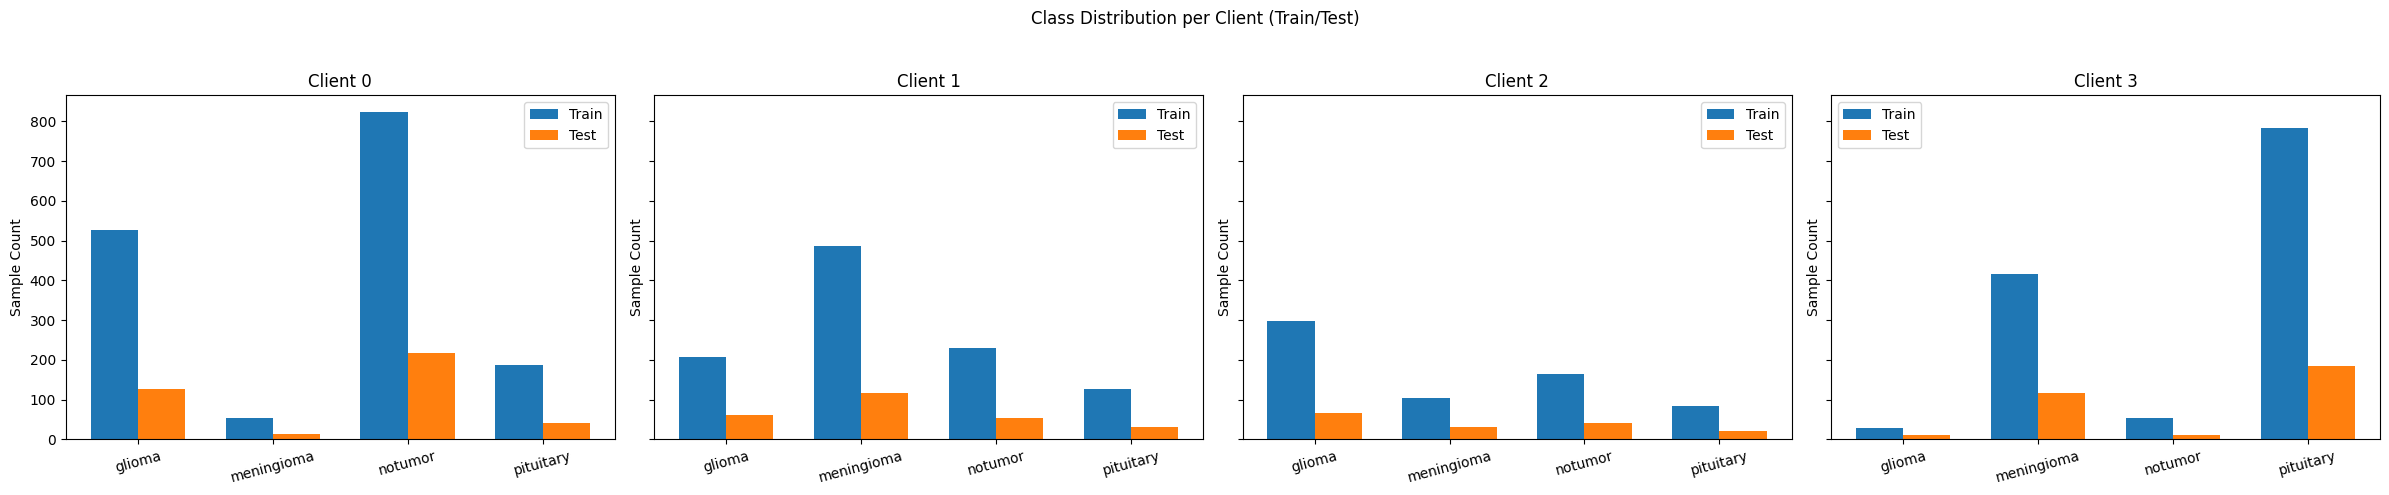

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
